In [44]:
import pandas as pd
from sklearn import model_selection, preprocessing
from sklearn import tree, linear_model, svm, ensemble, metrics
import matplotlib
from matplotlib import pyplot as plt
import xgboost as xgb
import scipy
import numpy as np

import compare_y
import cross_validation_result as cvr
import ML_helper

%matplotlib inline

In [101]:
# PSL simulation with prior rule

TRUTH_linear = "../psl/data/simulation/linear/seed0/cross_val_6fold/"
INFER_linear = "../psl/result/simulation/linear/with_prior/"
mse_linear, rho_linear = cvr.cross_val_result(TRUTH_linear, INFER_linear)
TRUTH_random = "../psl/data/simulation/random/seed0/cross_val_6fold/"
INFER_random = "../psl/result/simulation/random/with_prior/"
mse_random, rho_random = cvr.cross_val_result(TRUTH_random, INFER_random)
mse_df = pd.DataFrame({"linear": mse_linear, "random": mse_random})
rho_df = pd.DataFrame({"linear": rho_linear, "random": rho_random})

f, ax = plt.subplots(2, 1, figsize=(6,9), tight)
mse_df.mean().plot.bar(ax=ax[0], yerr=mse_df.std(), sharex=True, fontsize=15)
rho_df.mean().plot.bar(ax=ax[1], yerr=rho_df.std(), ylim=(-0.1, 1.1), fontsize=15, rot=0)
ax[0].set_title("PSL simulation result", fontsize=15)
ax[0].set_ylabel("Mean Squared Error", fontsize=15)
ax[1].set_ylabel("Spearman Rank Coefficient", fontsize=15)

SyntaxError: non-keyword arg after keyword arg (<ipython-input-101-12c08390266a>, line 12)

In [93]:
# what if there is no prior in PSL rules?

TRUTH_linear = "../psl/data/simulation/linear/seed0/cross_val_6fold/"
INFER_linear = "../psl/result/simulation/linear/no_prior/"
linear_df = cvr.cross_val_result(TRUTH_linear, INFER_linear)

TRUTH_random = "../psl/data/simulation/random/seed0/cross_val_6fold/"
INFER_random = "../psl/result/simulation/random/no_prior/"
random_df = cvr.cross_val_result(TRUTH_random, INFER_random)

print linear_df
print random_df

        val_mse  val_rho
0  7.991461e-16      1.0
1  7.652288e-16      1.0
2  7.386355e-16      1.0
3  7.540871e-16      1.0
4  7.713779e-16      1.0
5  7.562180e-16      1.0
    val_mse   val_rho
0  0.165645 -0.015764
1  0.174145 -0.011020
2  0.162675 -0.011584
3  0.134763  0.169772
4  0.150627  0.081709
5  0.166939 -0.024205


In [5]:
Classifiers = {"XGBoost": xgb.XGBRegressor(n_estimators=200),
               "Linear": linear_model.LinearRegression()}

In [6]:
# run linear regression on simulated data

X1, linear_Y = ML_helper.load_data("../data/similuated_matrix_linear.tsv")
X2, random_Y = ML_helper.load_data("../data/similuated_matrix_random.tsv")

poly = preprocessing.PolynomialFeatures(2)
X1 = poly.fit_transform(X1)
X2 = poly.fit_transform(X2)

mse1, rho1 = ML_helper.run_cross_val(X1, linear_Y, Classifiers, n_fold=6)

print "linear"
print mse1
print rho1

mse2, rho2 = ML_helper.run_cross_val(X2, random_Y, Classifiers, n_fold=6)

print "\n random"
print mse2
print rho2

    XGBoost        Linear
1  0.002574  2.493724e-30
2  0.002926  1.736232e-30
3  0.002594  2.057049e-30
4  0.002786  2.466419e-30
5  0.003105  2.276499e-30
6  0.002397  3.224397e-30
    XGBoost  Linear
1  0.987402     1.0
2  0.989021     1.0
3  0.989299     1.0
4  0.987138     1.0
5  0.986233     1.0
6  0.990248     1.0

 random
    XGBoost    Linear
1  0.086973  0.089826
2  0.089992  0.108167
3  0.104357  0.113125
4  0.095079  0.105462
5  0.091249  0.121354
6  0.091450  0.111977
    XGBoost    Linear
1  0.064874  0.148875
2  0.204649  0.115848
3 -0.105929  0.008610
4 -0.109604 -0.010253
5  0.022705 -0.067232
6  0.103770  0.010276


In [8]:
mean1 = mse1.mean()
mean1["PSL"] = linear_df["val_mse"].mean()
print mean1

plt.figure(1)
plt.title("linear data mean squared error")
mean1.plot(kind="bar", yerr=mse1.std())
plt.xticks(rotation='vertical')


plt.figure(2)
plt.title("random data mean squared error")
mean2 = mse2.mean()
mean2["PSL"] = random_df["val_mse"].mean()

mean2.plot(kind="bar", yerr=mse2.std())

NameError: name 'linear_df' is not defined

In [ ]:
mse_means = []
mse_stds = []
rho_means = []
rho_stds = []
for df in [psl_df, psl_df_minmax, psl_df_minmax_cuberoot]:
    mse_means.append(float(df["val_mse"].mean()))
    mse_stds.append(float(df['val_mse'].std()))
    rho_means.append(float(df["val_rho"].mean()))
    rho_stds.append(float(df['val_rho'].std()))

N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, mse_means, width, color='r', yerr=mse_stds)
rects2 = ax.bar(ind + width, rho_means, width, color='y', yerr=rho_stds)

# add some text for labels, title and axes ticks
ax.set_ylabel('')
ax.set_title('Comparing different raw data scaling')
ax.set_xticks(ind + width)
ax.set_xticklabels(('Rank', 'MinMax', 'MinMax cube root'))

ax.legend((rects1[0], rects2[0]), ('MSE', 'Spearman'), loc="best")

          a         b         c         d
0  0.966900  0.404769  0.776627  0.417240
1  0.307263  0.556697  0.251976  0.789361
2  0.734285  0.208212  0.639192  0.090652
3  0.018942  0.085118  0.891525  0.052128
4  0.514739  0.853549  0.531067  0.738839
5  0.541823  0.840637  0.745839  0.512608
6  0.634437  0.751397  0.121550  0.692197
7  0.271856  0.225804  0.569925  0.128546
8  0.075240  0.162360  0.957881  0.990864
9  0.767346  0.049485  0.496643  0.281450


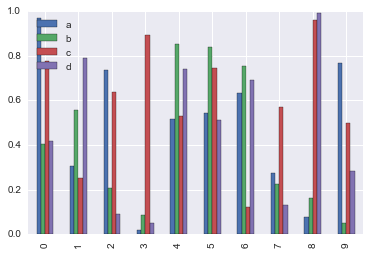